# **Introduction**

Hey Everyone, My Name is **Nacir Bouazizi** and in this notebook I am going to show how simply add coco pretrained weights and get a **score > 0.735** without Pseudo Labeling and **> 0.76** with Pseudo Labeling . I am going to make this as easy as possible for everyone to make their submission.

Don't Forget to **Upvote** this notebook if you find it helpful.

Ps : this notebook is based on the great work of [OrKatz](https://www.kaggle.com/orkatz2) which you can find it [here](https://www.kaggle.com/orkatz2/yolov5-train) + Some useful tips to make training with coco pretrained weights easier for everyone + Useful tips to train on Colab without having runtime issues. So I hope you enjoy reading it as much as I did writing it.

Let's start with importing some useful Modules :

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.auto import tqdm
import shutil as sh

Let's copy the content of yolov5 to our current directory.

In [ ]:
!cp -r ../input/yolov5/* .

In [ ]:
#uncomment this line 
#!pip install -r requirements.txt

# Dataframe Creation : 

We have to make our data in a format that yolov5 accepts, and that's what we are doing below :

In [ ]:
df = pd.read_csv('../input/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [ ]:
df.head()

In [ ]:
df.image_id.nunique()

In [ ]:
index =  list(sorted(set(df.image_id)))

We are going to choose **fold 0** to be our **OOF**. **Fold 0** gave the **best** score compared to the other folds but we can't trust it as we may overfit. Maybe I'll post another notebook to show how to train on different folds and make an ensemble out of them if some of you asked for it. But now let's just take **fold 0** to show how much it is simple to use **Yolo5**.

🛑**PS** : this validation strategy is not that good but here we just want to show how to train using coco pretrained weights.


In [ ]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)

            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt"):   
              with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                  row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                  row = row/1024
                  row = row.astype(str)
                  for j in range(len(row)):
                      text = ' '.join(row[j])
                      f.write(text)
                      f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))

            if not os.path.exists('convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name)):    
              sh.copy("../input/global-wheat-detection/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

# Training: 

Now comes the good and easy part. Let's install **apex** first which will make our training faster. 

In [ ]:
# Apex install
#uncomment this line
#!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Now we will train our model using coco pretrained weights so below you can find the command and I'm going to explain important arguments in this command : 

In [ ]:
#uncomment this line 
#!python ./train.py --img 1024 --batch 2 --epochs 1 --data "../input/configyolo5v1/configYolo5v1/wheat0.yaml" --cfg "../input/yolov5yaml/yolov5xx.yaml"   --name yolov5x_fold0 --weights yolov5x.pt

* **--batch** : the batch size, and here I choose 2 because it gives the best results.
* **--epochs** : here I choose 1 but to just show you how it works. You can set it to **100**
* **--data** : it's path to the yaml file which contains the paths to our training data (which we stored in **convertor** directory)
* **--cfg** : the path to our custom yolov5 yaml config file.
* **--name** : after training this prefix s added to last and best so we get best_yolov5x_fold0.pt and last_yolov5x_fold0.pt.
* **--weights** : that's the most important argument, here we tell Yolov5 to use coco pretrained weights to train on our data.  


In [ ]:
rm -rf ./convertor

# What Next ? 

Training for 100 epochs takes alot of time and we can't do that on kaggle because we have limited ressources. So my advice would be to use Colab ( or Colab Pro if you can pay **10$/month**) 
But many are complaining about runtime errors and random disconnections on Colab. 
So here's how you can train on it and go to sleep 😃

**If you choose to use Normal Colab :** 

Every epoch takes 10 to 12 minutes so that's 16.6 to 20 hours to train for 100 epochs. 
Normal Colab gives you a session of 12 hours per day. so we can train up to 72 epochs (maximum) and 60 (minimum ) . That's not always the case but it's an approximation. 
So my advice would be :
* to train for 50 epochs and save your weights (which you can find in the weights folder) to your drive using this command : 

In [ ]:
#!cp "/content/weights/last_yolov5x_fold3.pt" "/content/drive/My Drive/your_path_here"
#!cp "/content/weights/best_yolov5x_fold3.pt" "/content/drive/My Drive/your_path_here"

**If you choose to use Colab Pro :**

You won't have a problem because you will have a 24 hours session 😃

**Avoid Runtime Erros and disconnections :** 

Many of you have been asking how to fix this because we loose everything everytime Colab disconnects and no one wants that especially in this competition 😢 So here's how to avoid it using a simple Javascript code. You can copy paste it in your console. **ctrl +Shift + I** to open it.

In [ ]:
"""""

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)

"""

Here's a screenshot to better illustrate my words. 

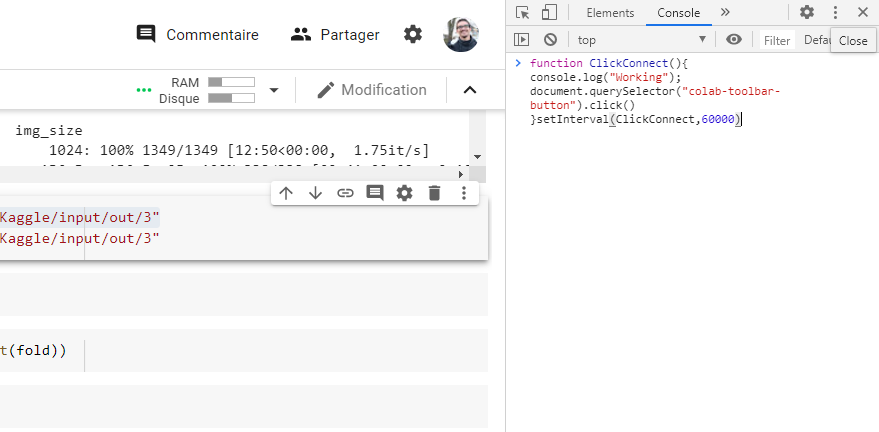

# **Next  ?** 

Go to sleep 😴.
And the next day you wakeup, train for the remaining epochs (if you use normal colab). 
When you finish training take a look on this great notebooks to make an inference : 
* [YoloV5 Pseudo Labeling](https://www.kaggle.com/nvnnghia/yolov5-pseudo-labeling)
* [YoloV5 fake or real [Single Model] L.B>0.753](https://www.kaggle.com/orkatz2/yolov5-fake-or-real-single-model-l-b-0-753)
* [YoloV5 [Single Model] with more TTA L.B>0.745](https://www.kaggle.com/wasupandceacar/yolov5-single-model-with-more-tta-lb-0-745)

I think I finished my job here, I hope you like this notebook, it's my first one. Upvote to see more content like this one. And feel free to ask anything below. I can help just ask 😊